In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
import pandas as pd
from tensorflow import keras
from utils.helper import (
    folder_to_sequence,
    MinMaxScaler_AE,
)

plt.style.use(["science", "ieee", "notebook"])

plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.figsize"] = (9, 4)

In [75]:
# carregando os dados para a memória
DEFAULT_WS = 40
normal = folder_to_sequence("VIDRO-B3", DEFAULT_WS)
anomaly1 = folder_to_sequence("ANOMALIAS/B3+200g", DEFAULT_WS)
anomaly2 = folder_to_sequence("ANOMALIAS/B3-200g", DEFAULT_WS)
anomaly3 = folder_to_sequence("PAINCO", DEFAULT_WS)
anomaly4 = folder_to_sequence("VIDRO-B2", DEFAULT_WS)

transient = folder_to_sequence("ANOMALIAS/Transiente", DEFAULT_WS)

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 15.72it/s]


In [76]:
scaler = MinMaxScaler_AE()
scaler.fit(normal)

In [77]:
autoencoder = keras.models.load_model("best_model.keras")

In [78]:
# 1) Analisar os erros no conjunto de treino


def get_error_dist(data: np.ndarray, color: str, cumulative=False, plot=True):
    xnorm = scaler.transform(data)
    xpred = autoencoder.predict(xnorm)

    xnorm = np.squeeze(xnorm, axis=-1)
    errors = np.mean(np.abs(xnorm - xpred), axis=1)

    max_error = np.percentile(errors, 95)

    if plot:
        fig, ax = plt.subplots()
        ax.grid()
        sns.histplot(
            errors,
            kde=True,
            bins=50,
            color=color,
            stat="percent",
            ax=ax,
            cumulative=cumulative,
        )
        ax.set_ylabel(r"Porcentagem (%)")
        ax.set_xlabel("Erro médio absoluto")
        return ax, max_error, errors

    return max_error, errors

1015/1015 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step
0.013683455446763828


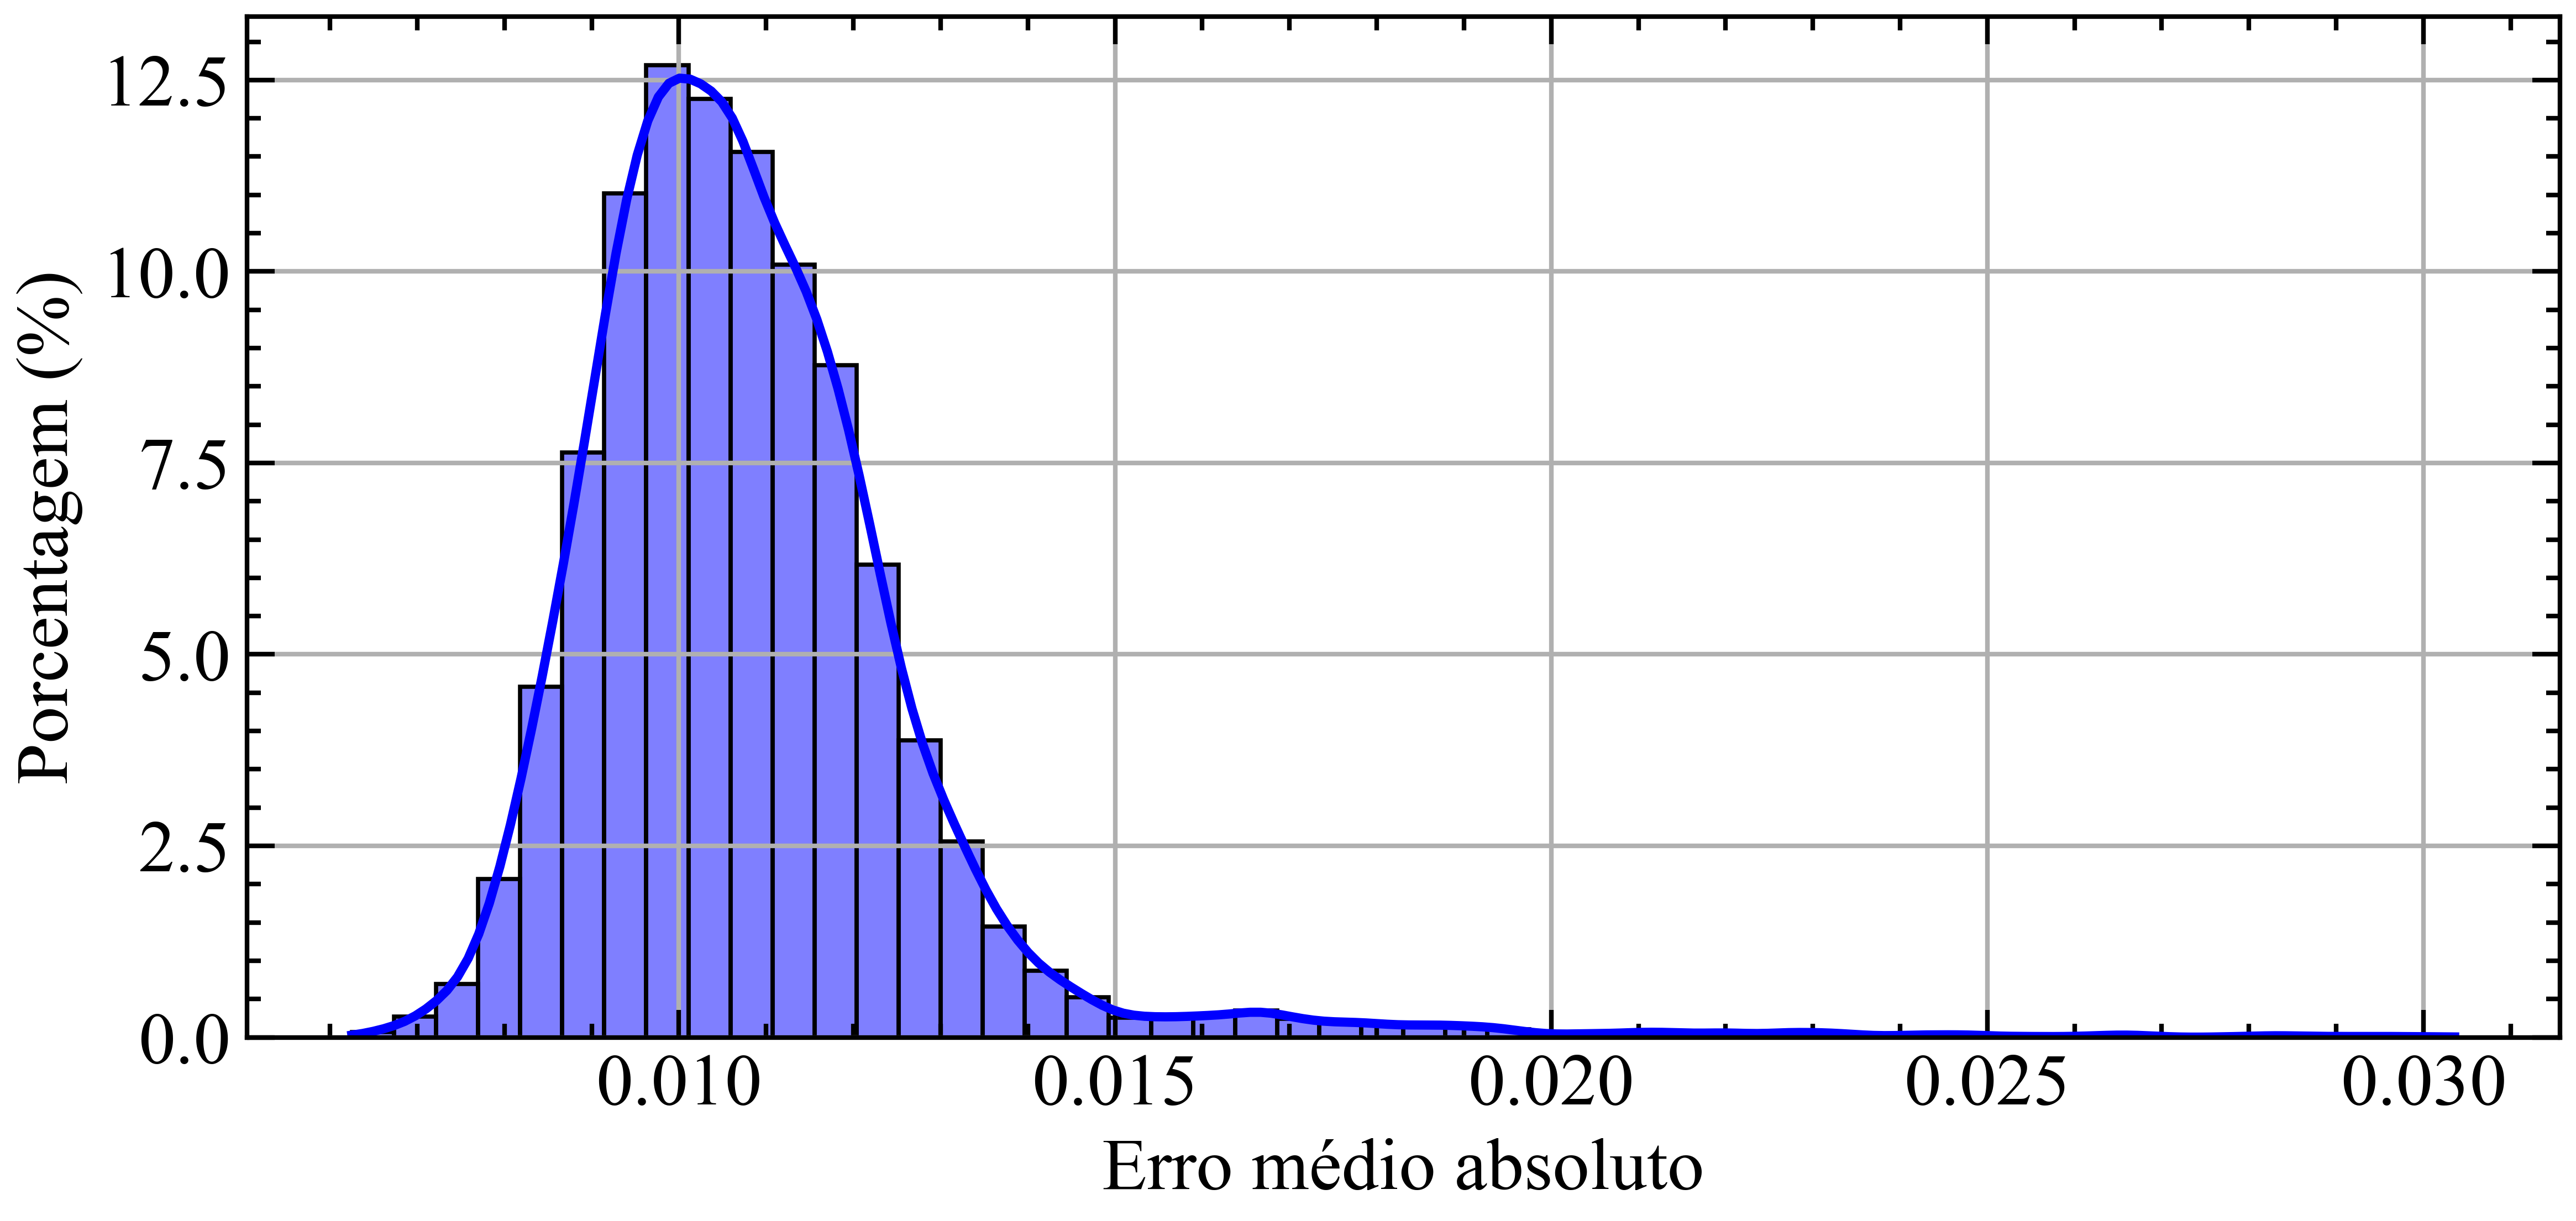

In [79]:
ax, max_error, _ = get_error_dist(normal, color="blue")
print(max_error)

In [80]:
def get_accuracy(errors: np.ndarray, threshold: float) -> float:
    anomalies = errors > threshold
    accuracy: float = np.mean(anomalies)
    return accuracy

273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


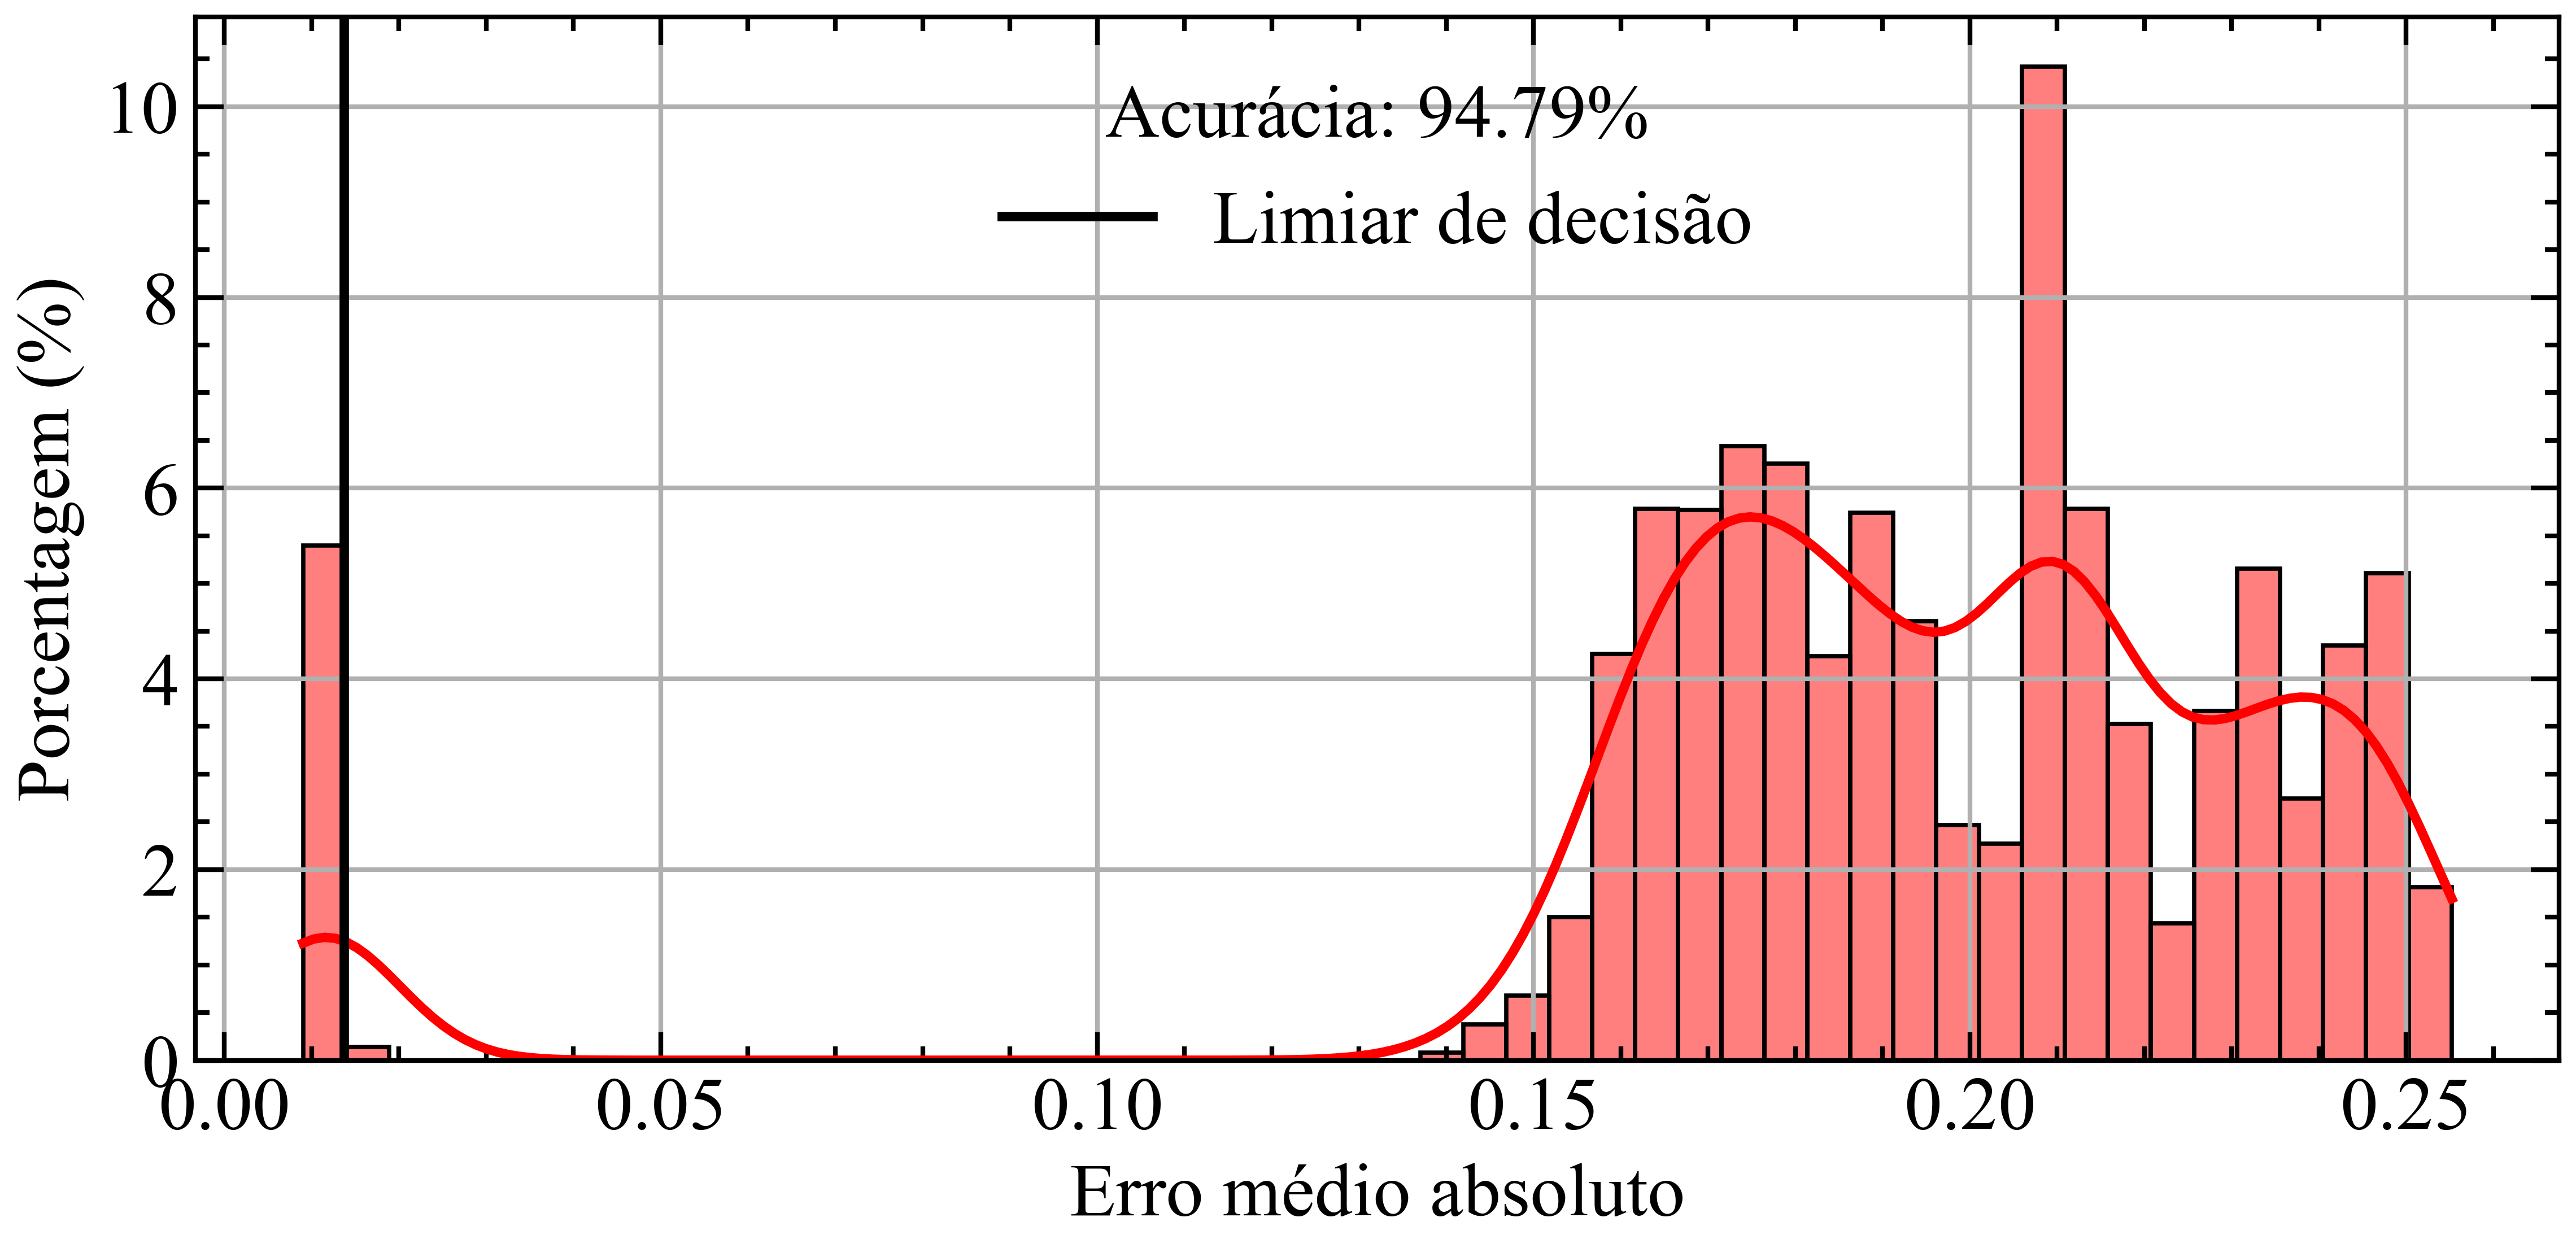

In [81]:
ax2, _, errors2 = get_error_dist(anomaly1, "red")
ax2.axvline(max_error, label="Limiar de decisão")
ax2.legend(title=f"Acurácia: {get_accuracy(errors2, max_error) * 100:.2f}%")

256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


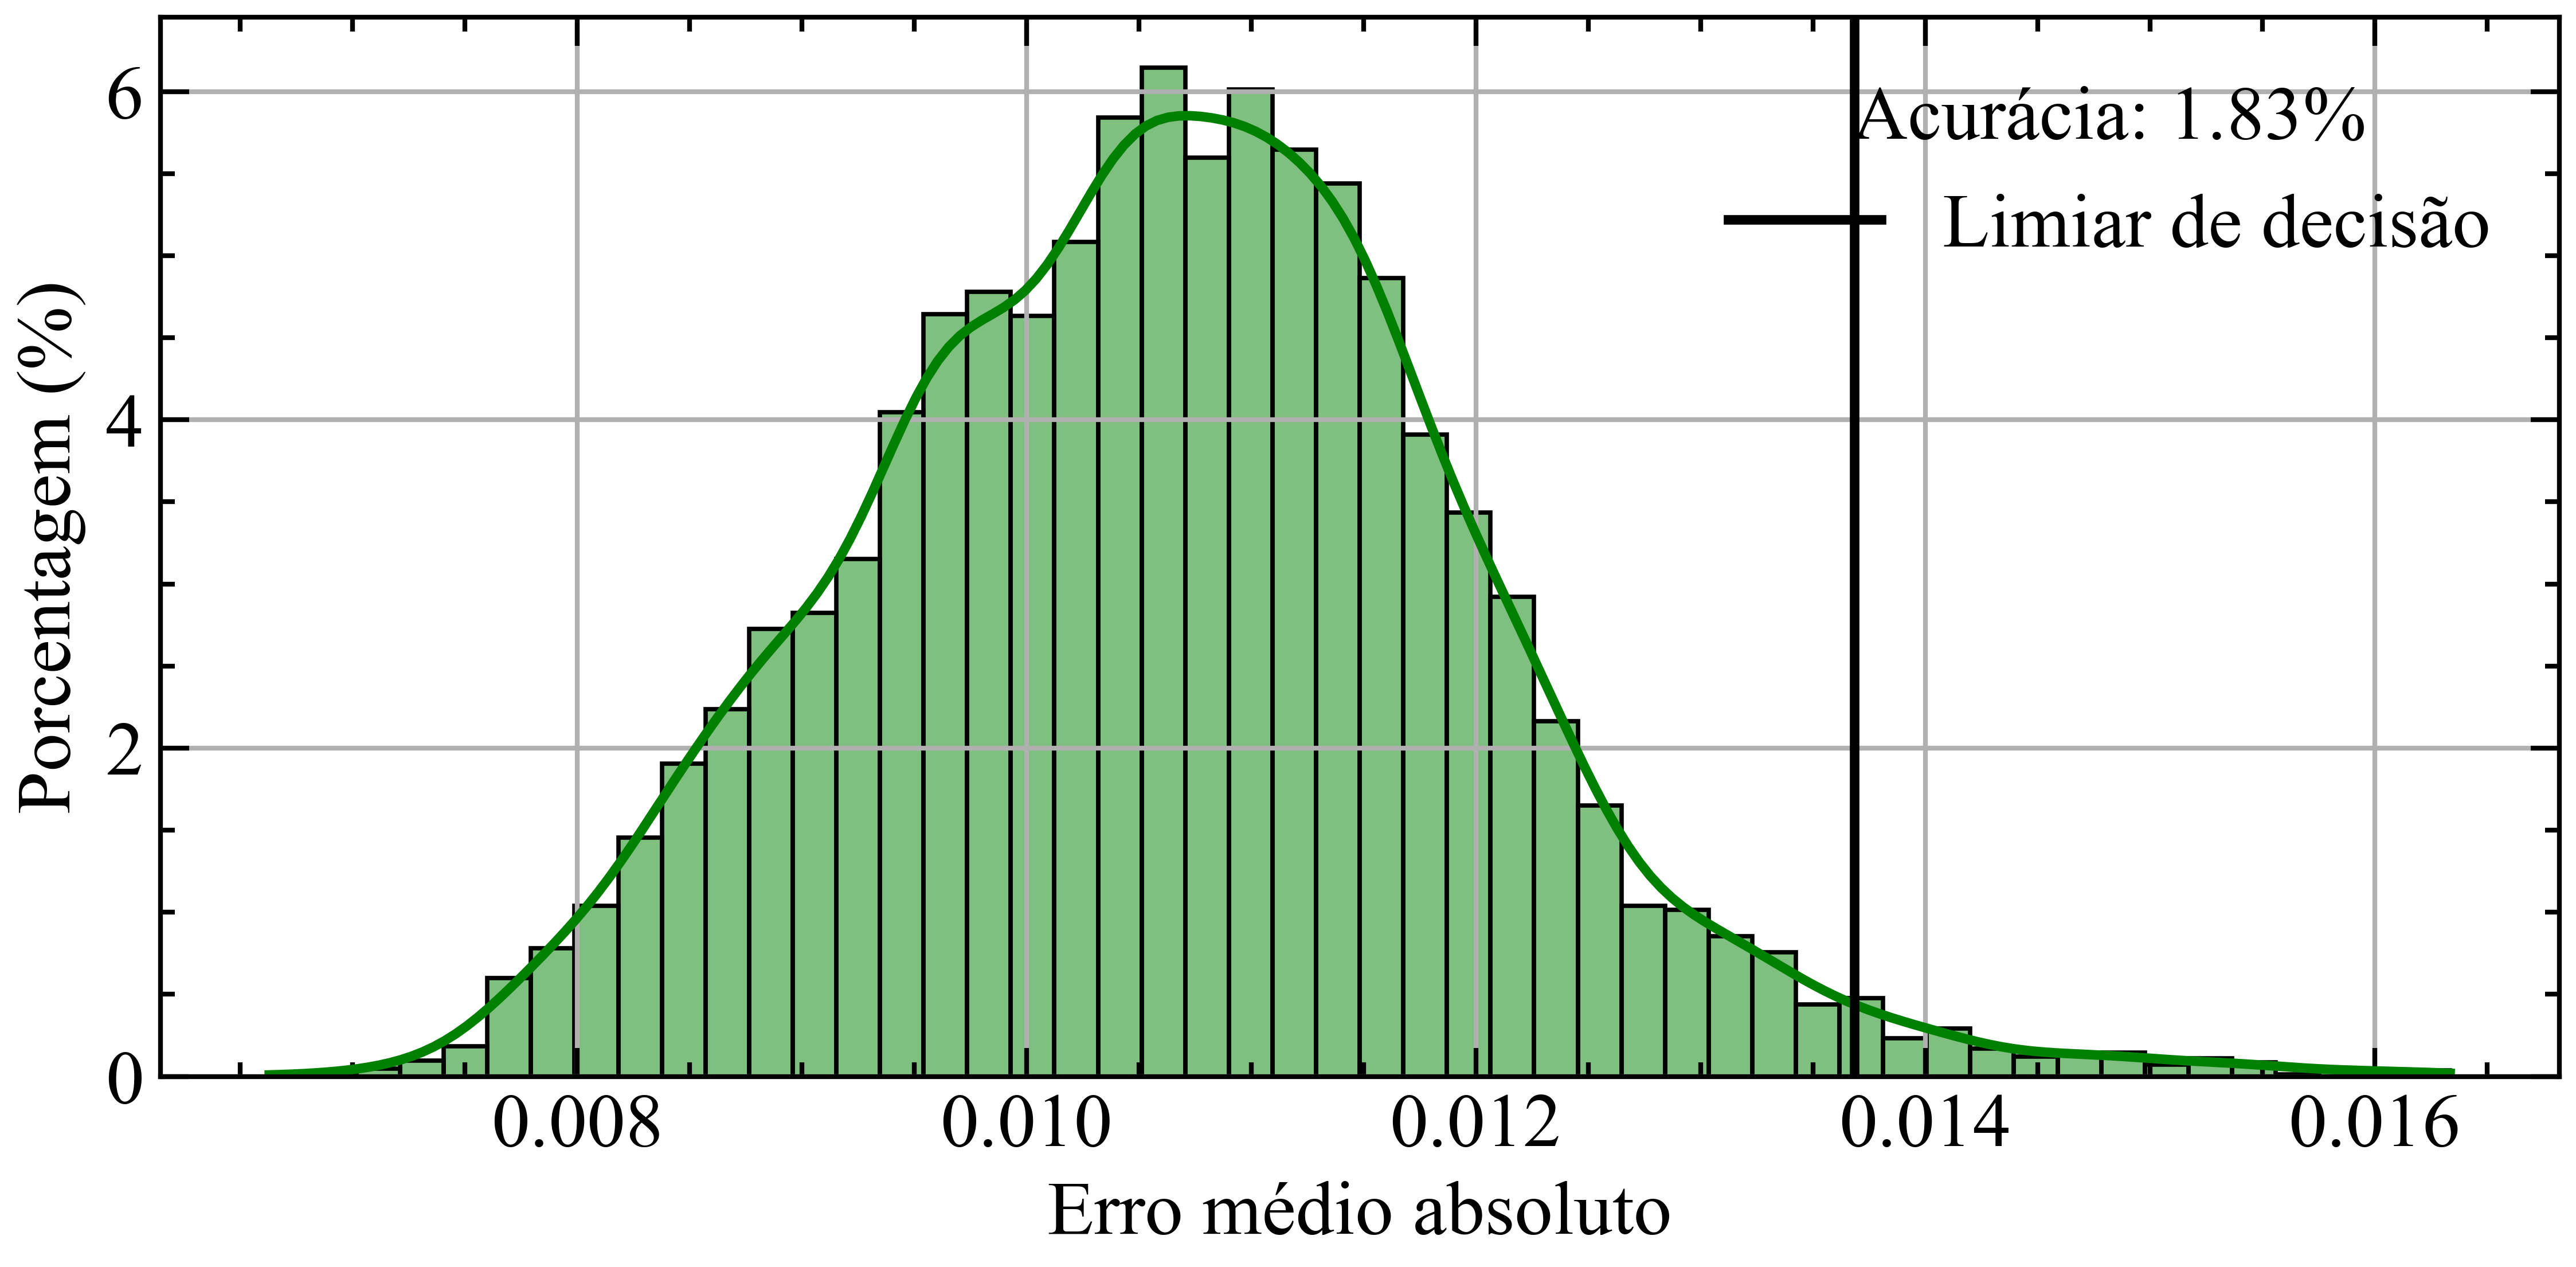

In [82]:
ax3, _, errors3 = get_error_dist(anomaly2, "green")
ax3.axvline(max_error, label="Limiar de decisão")
ax3.legend(title=f"Acurácia: {get_accuracy(errors3, max_error) * 100:.2f}%")

216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


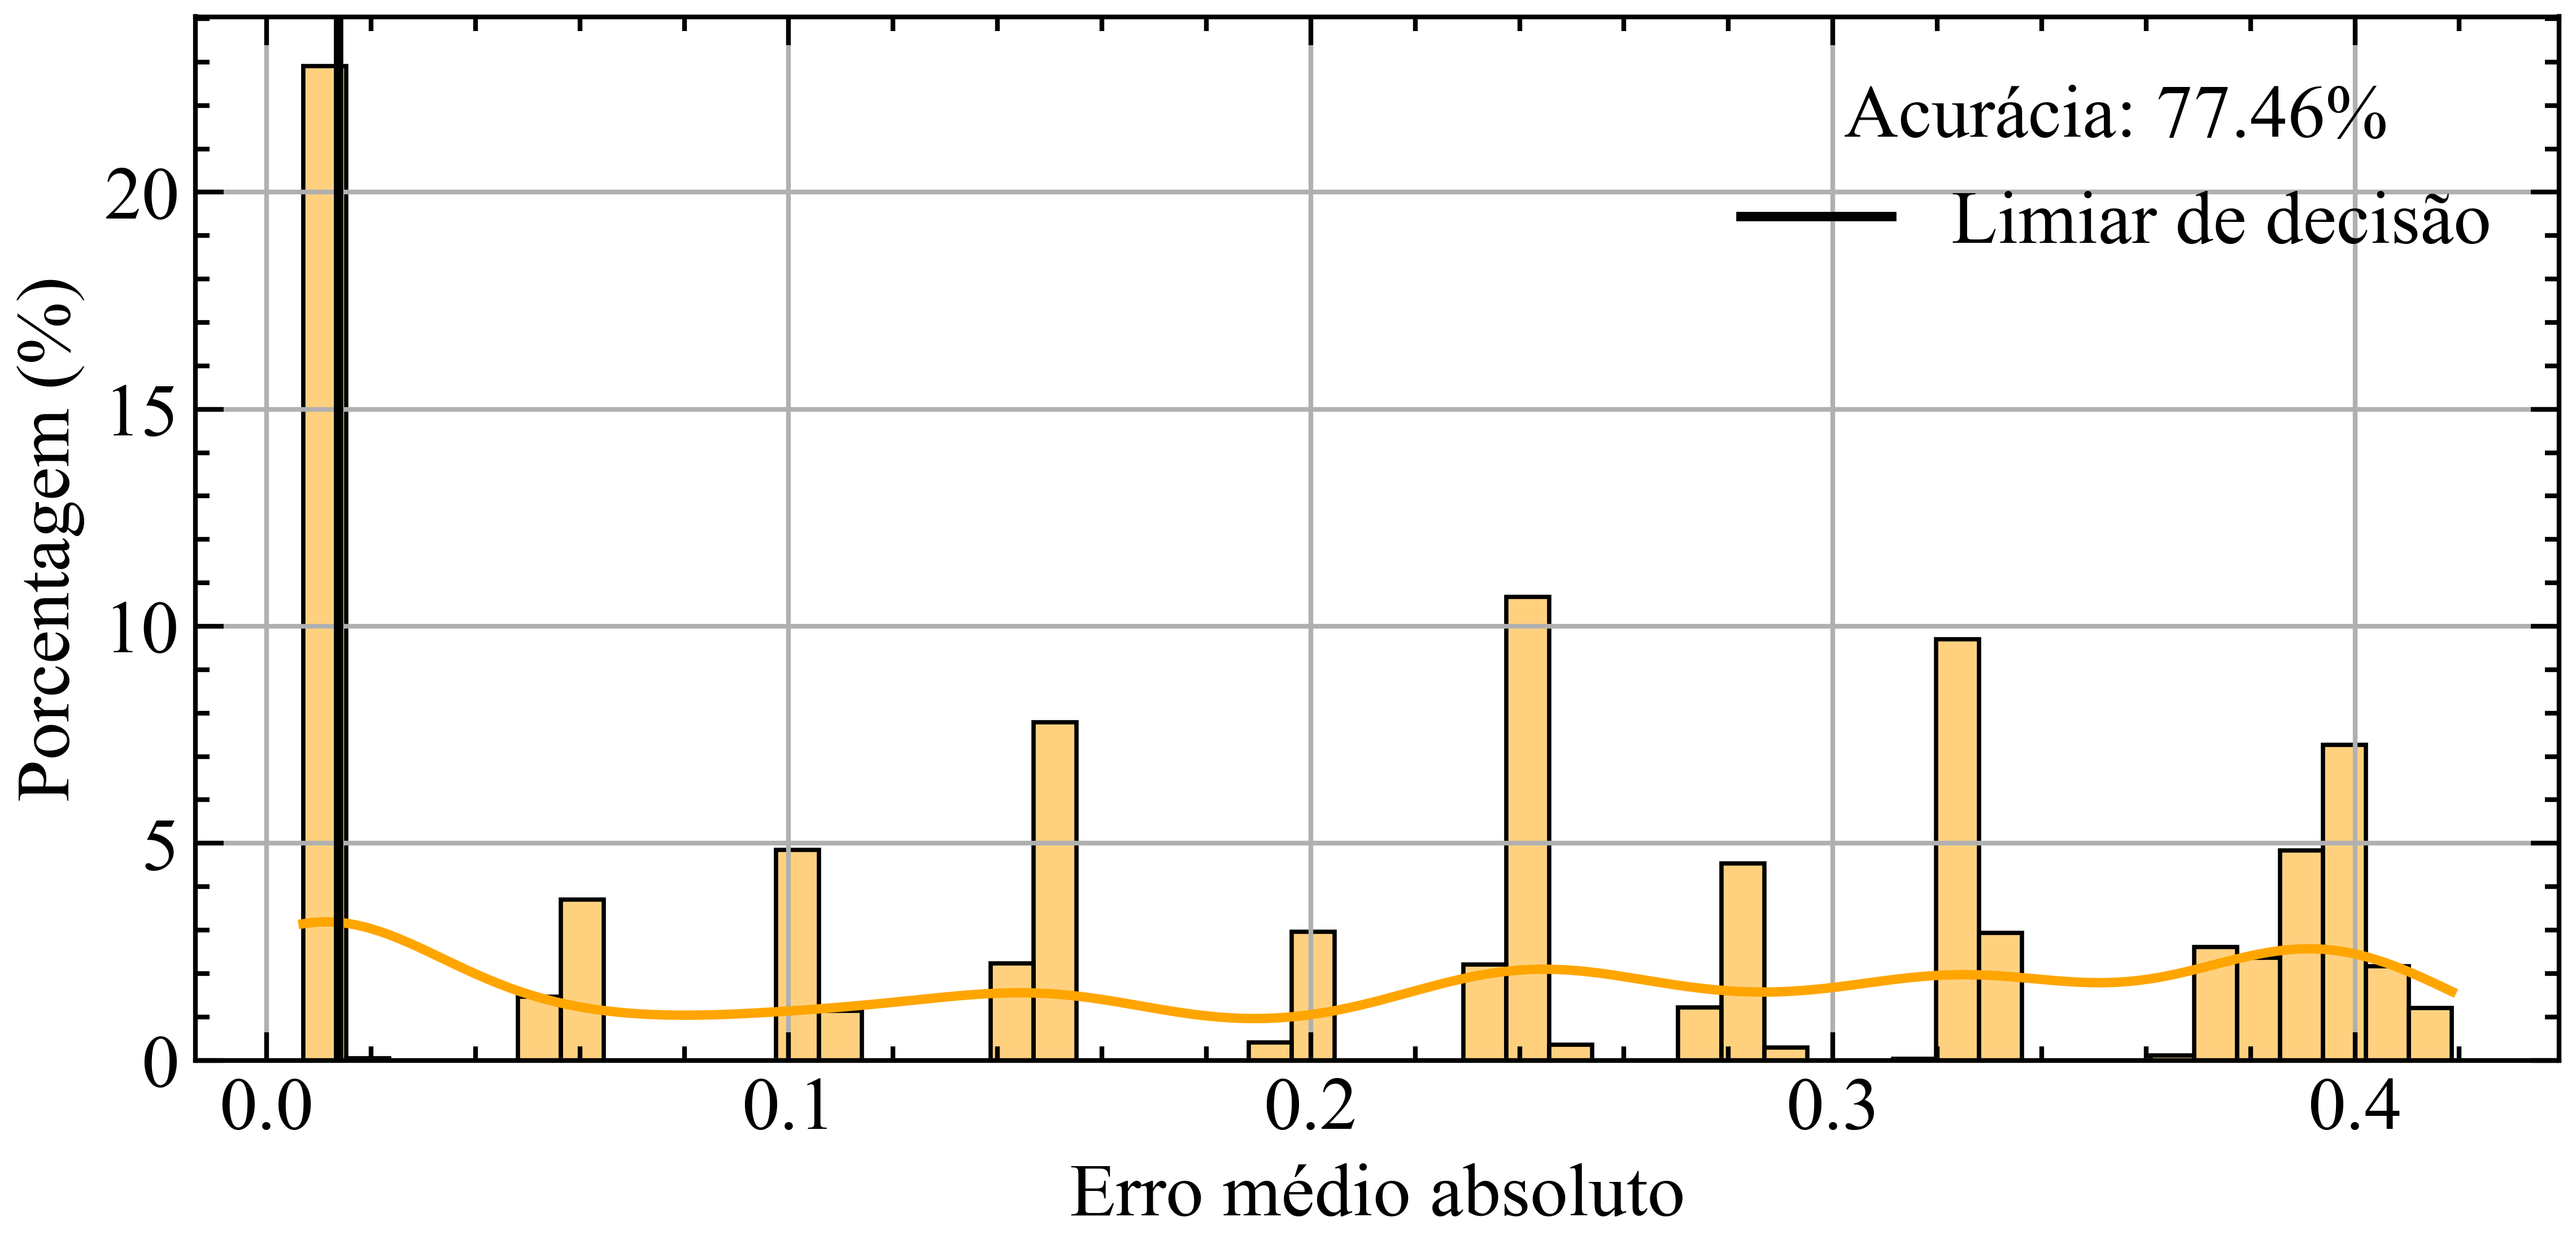

In [83]:
ax4, _, errors4 = get_error_dist(anomaly3, "orange")
ax4.axvline(max_error, label="Limiar de decisão")
ax4.legend(title=f"Acurácia: {get_accuracy(errors4, max_error) * 100:.2f}%")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


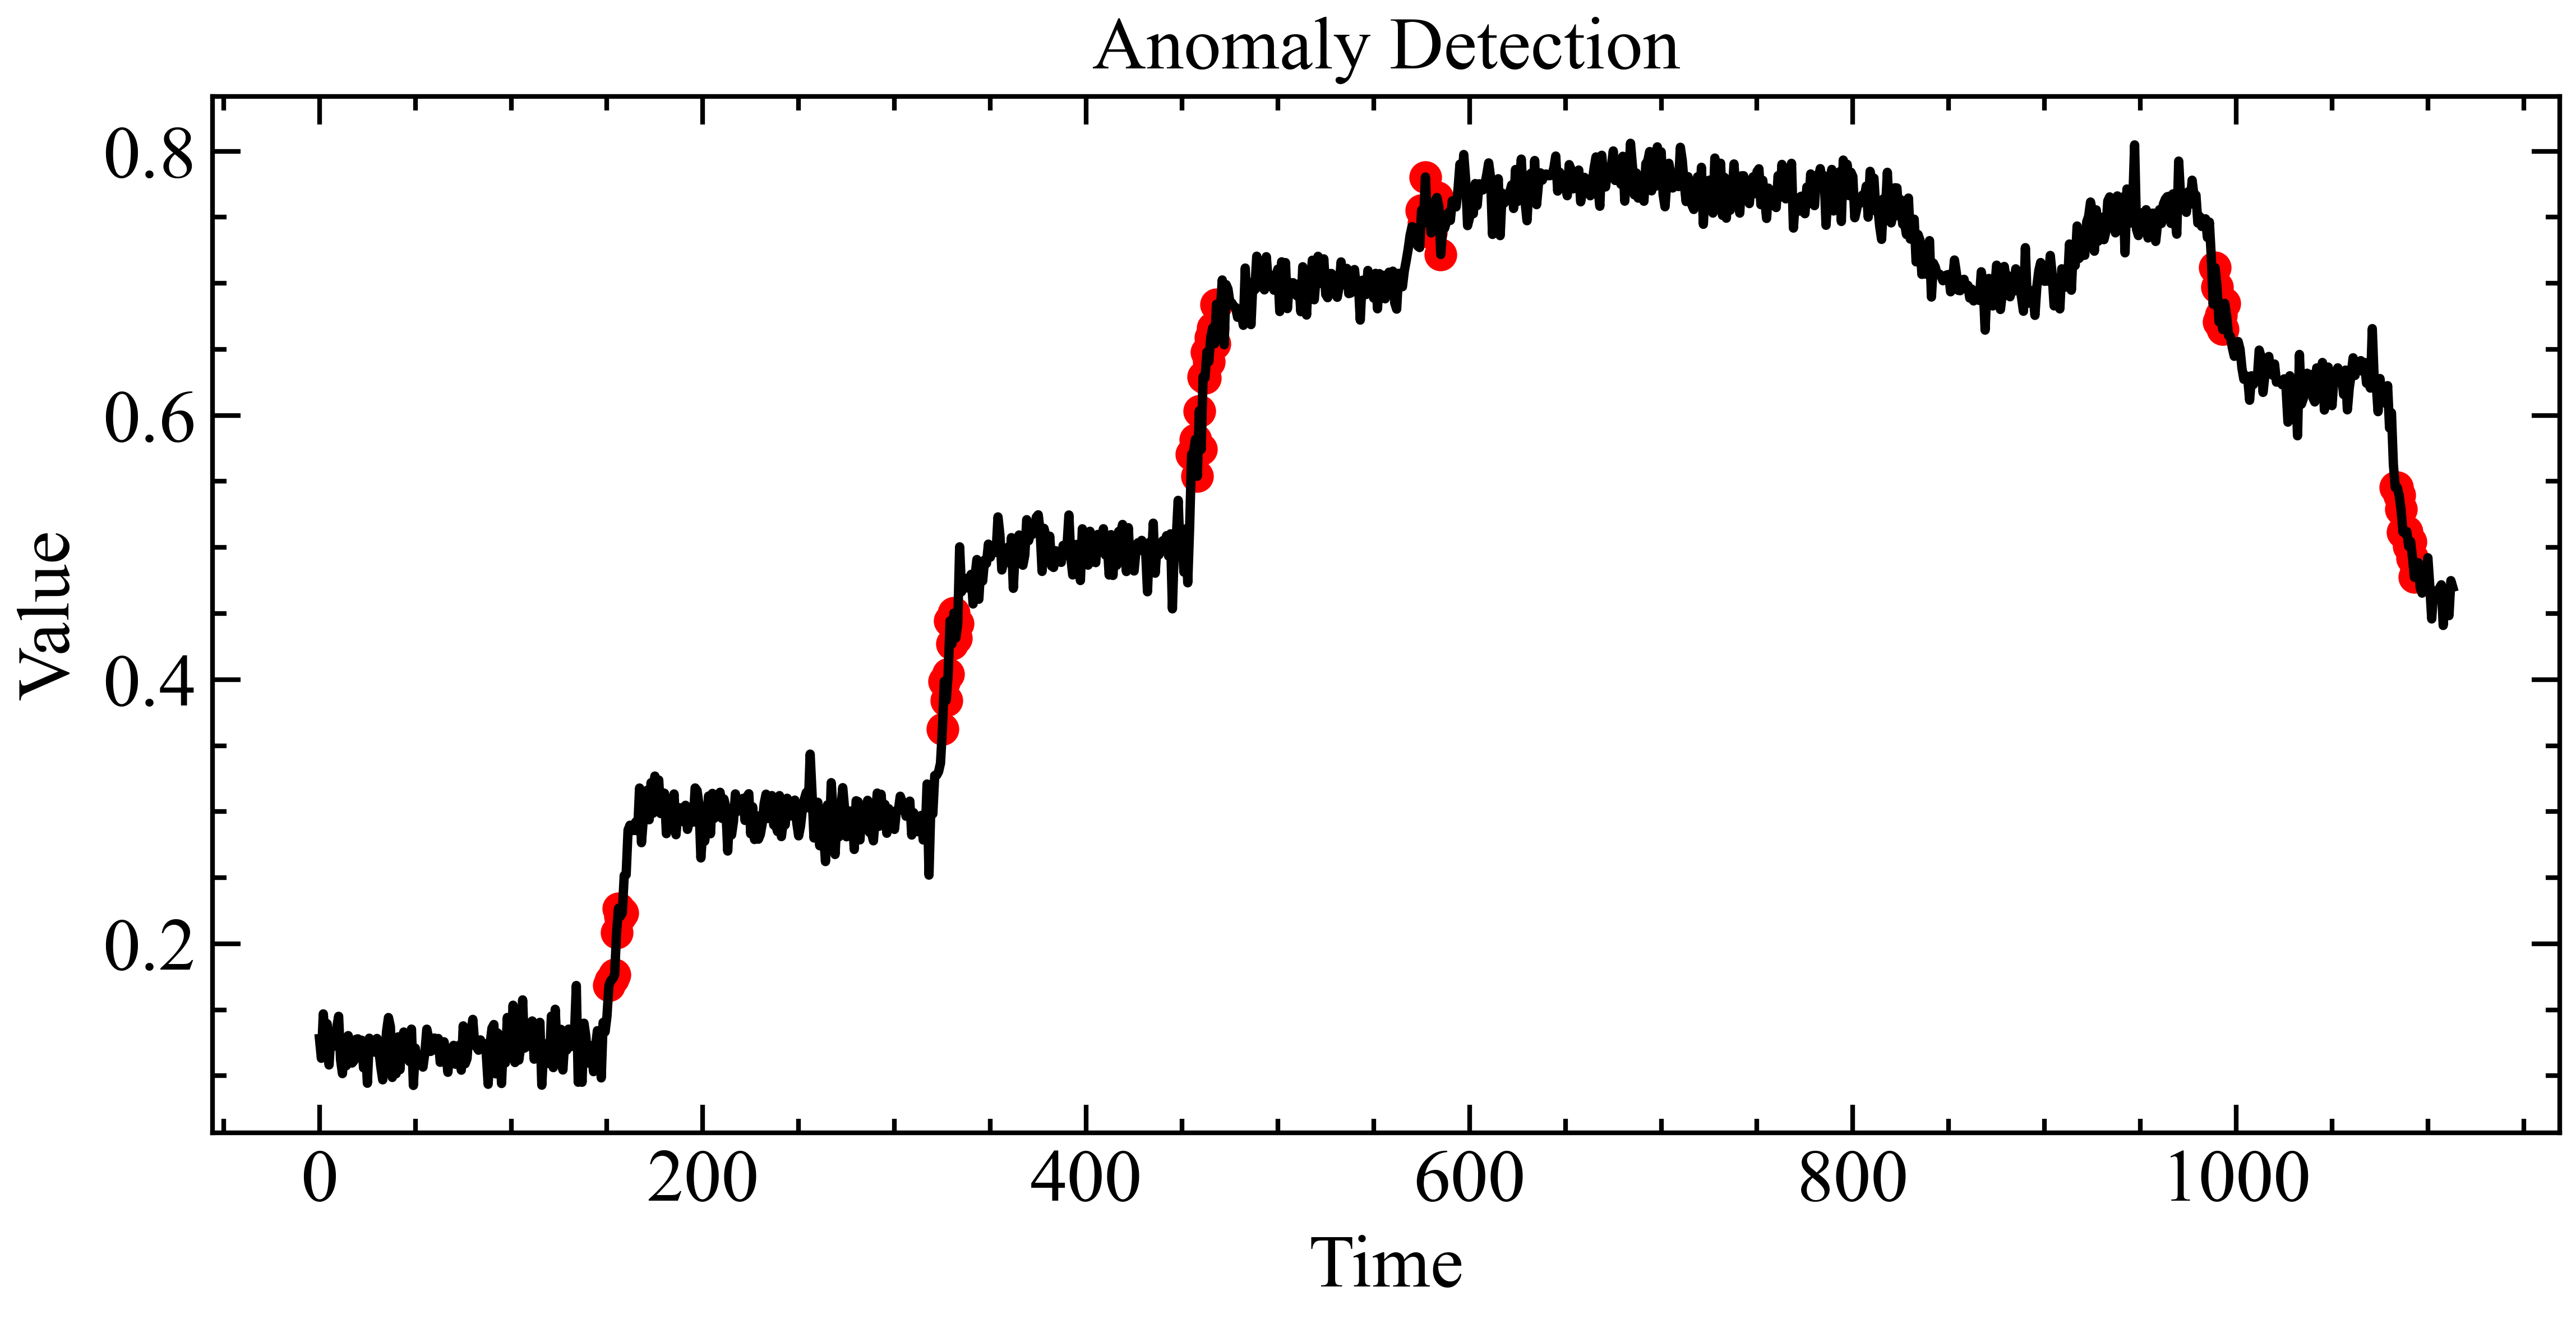

In [84]:
def plot_anomalies(data: np.ndarray, errors: np.ndarray, max_error: float, window_size: int = DEFAULT_WS):
    anomaly_points = errors > max_error
    combined_anomaly_points = np.zeros_like(anomaly_points, dtype=bool)
    for i in range(window_size - 1, len(anomaly_points)):
        if np.all(anomaly_points[i - window_size + 1 : i + 1]):
            combined_anomaly_points[i] = True

    fig, ax = plt.subplots()
    ax.plot(data[:, 0, 0])
    ax.scatter(
        np.where(combined_anomaly_points)[0], data[combined_anomaly_points, 0, 0], c="r"
    )
    ax.set_title("Anomaly Detection")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    return fig, ax

# Exemplo de uso da função
_, errors5 = get_error_dist(transient, "purple", plot=False)
fig, ax = plot_anomalies(transient, errors5, max_error)
plt.show()

230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


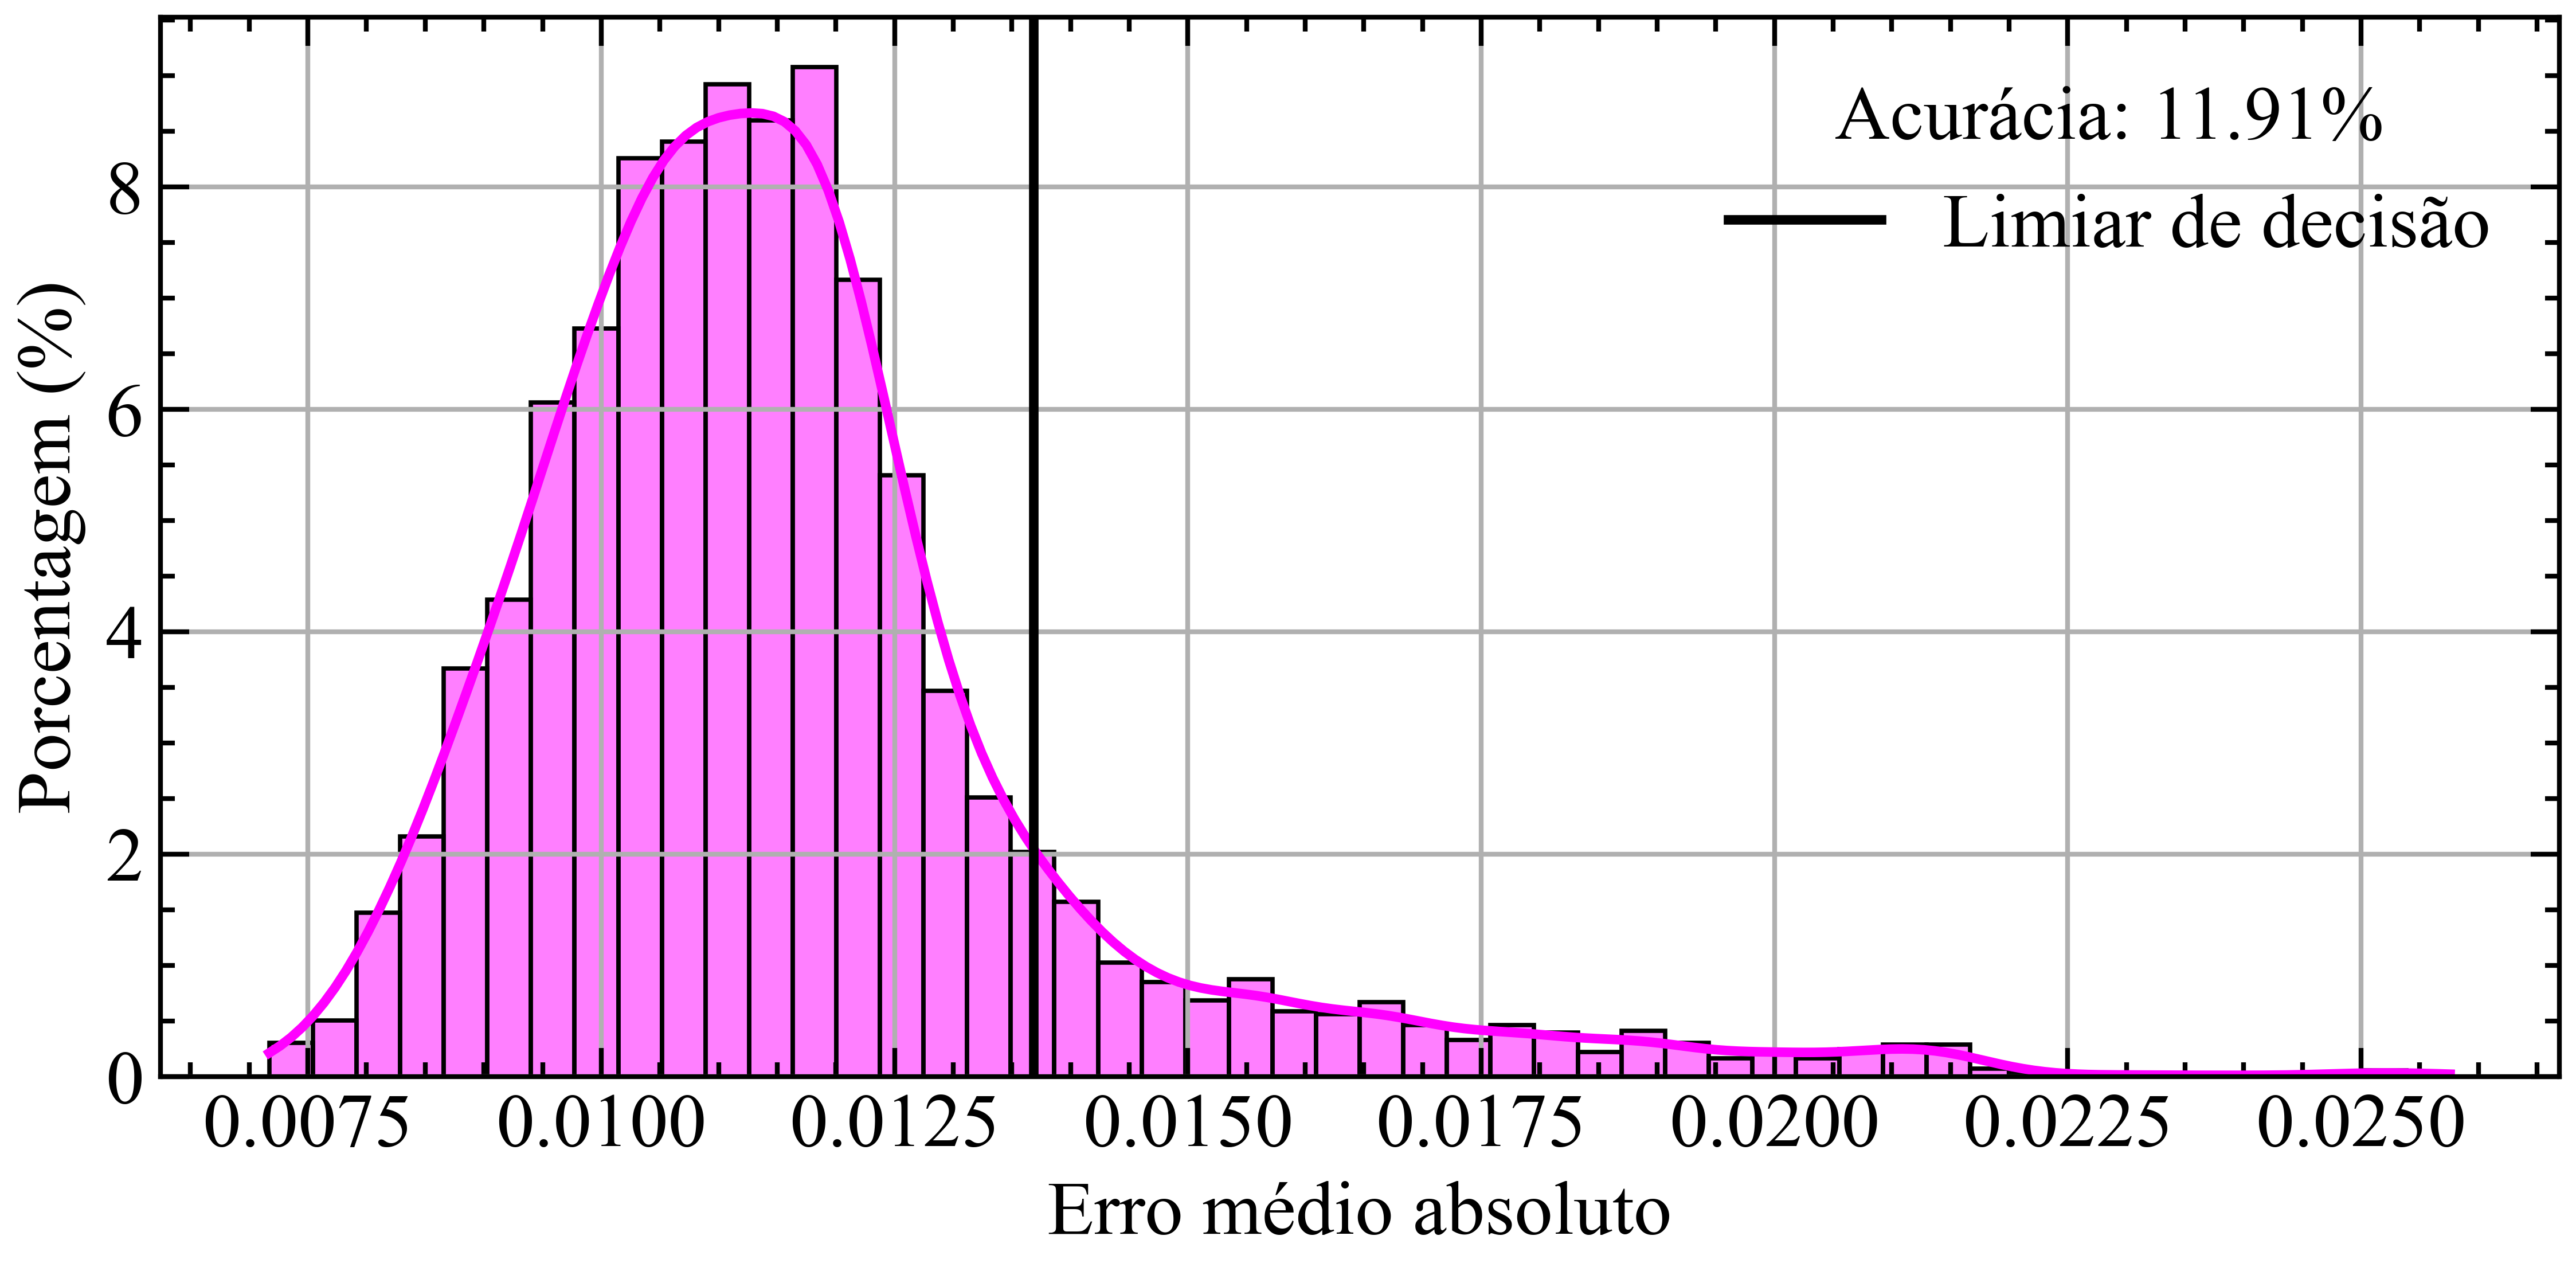

In [85]:
ax5, _, errors5 = get_error_dist(anomaly4, "magenta")
ax5.axvline(max_error, label="Limiar de decisão")
ax5.legend(title=f"Acurácia: {get_accuracy(errors5, max_error) * 100:.2f}%")

230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


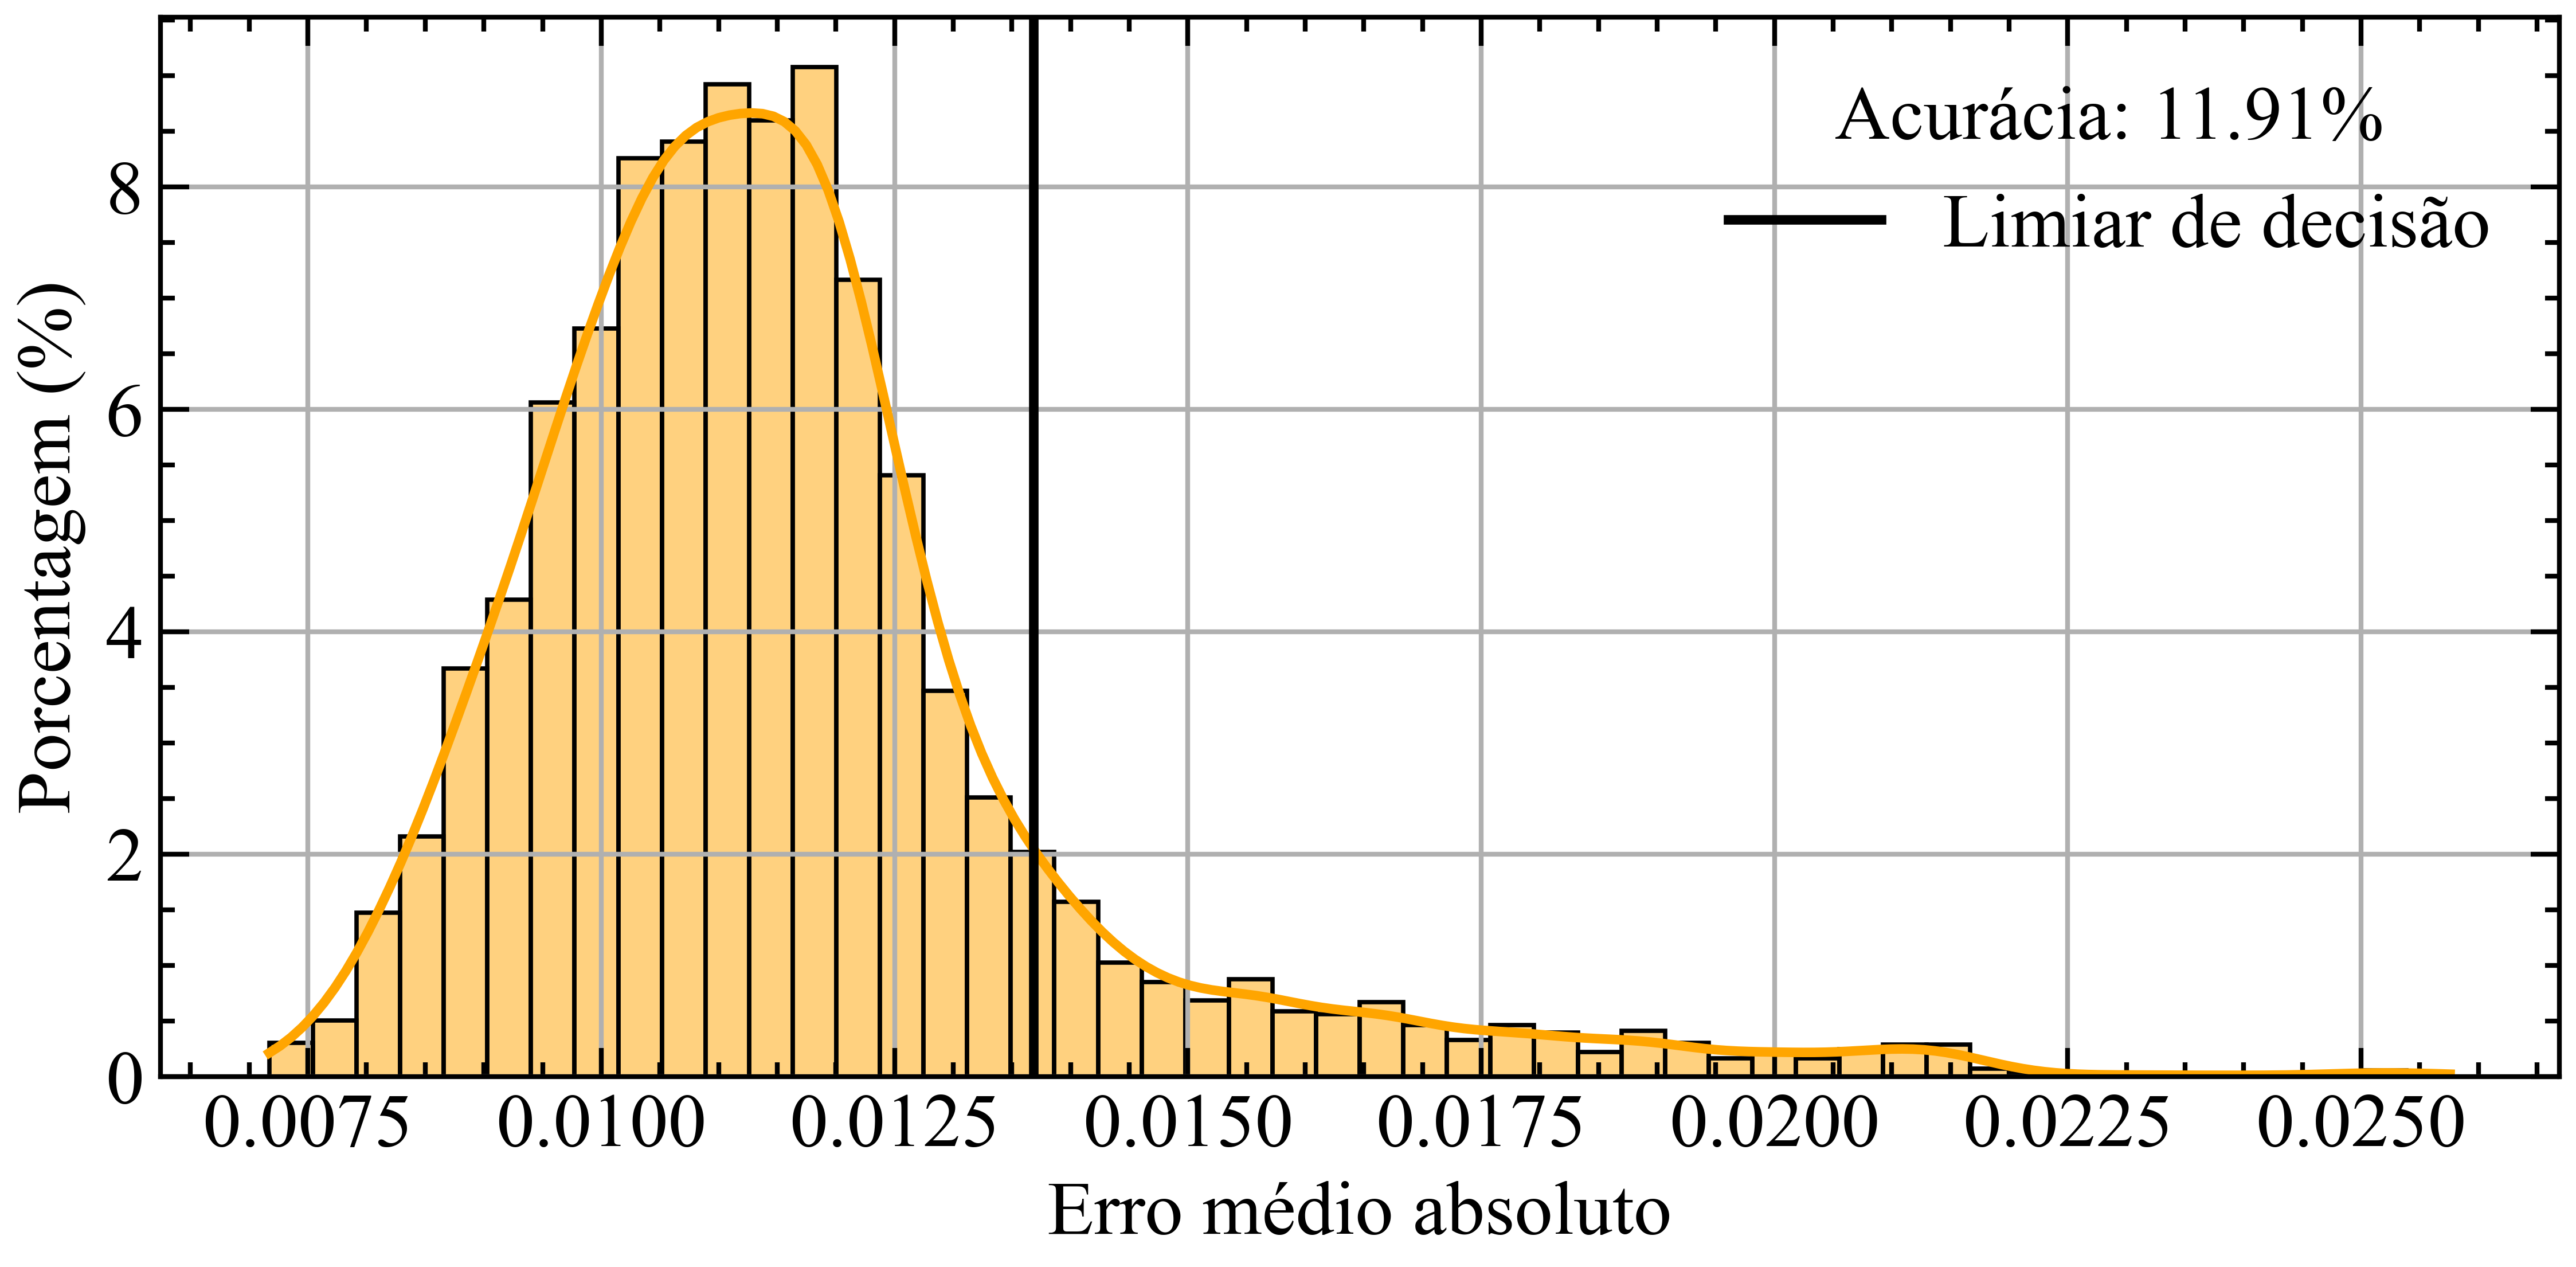

In [86]:
ax6, _, errors5 = get_error_dist(anomaly4, "orange")
ax6.axvline(max_error, label="Limiar de decisão")
ax6.legend(title=f"Acurácia: {get_accuracy(errors5, max_error) * 100:.2f}%")

In [87]:
def calculate_thresholds_and_accuracies(normal_data, anomaly_data_list, percentiles=[90, 95, 100]) -> pd.DataFrame:
    # Normalize the normal data
    xnorm = scaler.transform(normal_data)
    xpred = autoencoder.predict(xnorm)
    xnorm = np.squeeze(xnorm, axis=-1)
    errors = np.mean(np.abs(xnorm - xpred), axis=1)
    
    # Calculate thresholds based on percentiles
    thresholds = {p: np.percentile(errors, p) for p in percentiles}
    
    # Calculate accuracies for each anomaly dataset
    accuracies = {p: [] for p in percentiles}
    for anomaly_data in anomaly_data_list:
        xnorm_anomaly = scaler.transform(anomaly_data)
        xpred_anomaly = autoencoder.predict(xnorm_anomaly)
        xnorm_anomaly = np.squeeze(xnorm_anomaly, axis=-1)
        errors_anomaly = np.mean(np.abs(xnorm_anomaly - xpred_anomaly), axis=1)
        
        for p in percentiles:
            threshold = thresholds[p]
            accuracy = get_accuracy(errors_anomaly, threshold)
            accuracies[p].append(accuracy)
    
    # Create a DataFrame to store the results
    results = pd.DataFrame({
        'Percentile': percentiles,
        'Threshold': [thresholds[p] for p in percentiles],
    })
    
    for i, anomaly_data in enumerate(anomaly_data_list):
        results[f'Anomaly {i+1} Acc (%)'] = [accuracies[p][i]*100 for p in percentiles]
    
    return results

# Lista de dados de anomalias
anomaly_data_list = [anomaly1, anomaly2, anomaly3, anomaly4]

# Calcular a tabela de limiares e acurácias
results_table = calculate_thresholds_and_accuracies(normal, anomaly_data_list)
results_table.set_index('Percentile', inplace=True)
print(results_table)

1015/1015 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
            Threshold  Anomaly 1 Acc (%)  Anomaly 2 Acc (%)  \
Percentile                                                    
90           0.012762          95.557851           5.450990   
95           0.013683          94.788797           1.833293   
100          0.030357          94.467401           0.000000   

            Anomaly 3 Acc (%)  Anomaly 4 Acc (%)  
Percentile                                        
90                  77.563172          18.854025  
95                  77.461516          11.909959  
100                 77.054894           0.000000  
